In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from data.aware_raw import AwareRaw, AwareSpectrogram
from data.cats_and_dogs import Dataset

classes = [
    'Control / healthy / no pulmonary disease',
    'Asthma'
]
dataset_raw = AwareRaw("data/AWARE_DATA_LABELS_2023-12-08_1611.csv", "data/id_map.csv", "data/aware_full_1704385505.db", pickle_file="data/aware_segmented.pkl")
dataset = AwareSpectrogram(dataset_raw, target_classes=classes, age_balanced=False, output_demogr=True, output_spiro_bdr=True)
# dataset.save_to_pickle('data/aware_spectrogram.pkl')

class_weights = compute_class_weight(
    'balanced', 
    classes=classes, 
    y=dataset.data['Participant:']
)
print("Class Weights:")
print(class_weights)

# dataset = Dataset("data/cats_and_dogs")

# class_weights = compute_class_weight(
#     'balanced', 
#     classes=[0,1], 
#     y=dataset.data['label']
# )
# print("Class Weights:")
# print(class_weights)

0it [00:00, ?it/s]

Class Weights:
[13.33333333  0.51948052]


In [3]:
# dataset_raw.save_to_pickle('data/aware_segmented.pkl')

'Dumping data to pickle file ...'

'Complete'

In [5]:
sptg, demogr, spiro_bdr, labels = dataset[0]
display(sptg.size())
display(demogr)
display(spiro_bdr)
display(labels)
display(len(dataset))
display(len(set(dataset.data['AWARE STUDY ID:'])))

torch.Size([1, 50, 224, 224])

array([ 16.2,   1. , 165. ,  47. ], dtype=float32)

AWARE STUDY ID:                       10.000000
Test Number                            1.000000
Post-BD                                0.000000
BDR (as percent of baseline FEV1)     -4.824561
BDR (as percent of predicted FEV1)    -3.800000
BDR (liters)                          -0.110000
BDR (difference in %preds)            -4.000000
Name: 0, dtype: float64

1

240

27

array([7.3869037e-04, 1.9452452e-03, 6.0151017e-04, 4.7783210e-04,
       4.2488056e-04, 5.2787457e-04, 1.3335710e-03, 7.2333125e-05,
       3.9172286e-04], dtype=float32)

[-0.07, 0.17, 0.34, 0.06, 0.22, 0.36, 0.04, 0.22, 0.38]

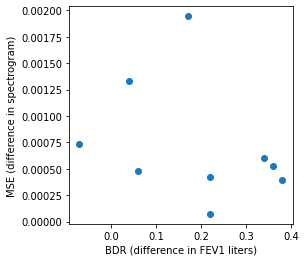

In [45]:
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import math

def plot(inputs, animate=False):
    d = math.isqrt(inputs.shape[0]-1)+1
    fig, axs = plt.subplots(d, d, figsize=(8,8))
    im = []
    if inputs.shape[0]==1:
        im += [axs.imshow(inputs[0,:,0,:,:].permute(1,2,0))]
    else:
        for i in range(inputs.shape[0]):
            # im += [axs[i//d, i%d].pcolormesh(inputs[i,0,0,:,:], shading='gouraud', cmap='gray')]
            im += [axs[i//d, i%d].imshow(inputs[i,:,0,:,:].permute(1,2,0))]
            axs[i//d, i%d].title.set_text("%.2f" % inputs[i,:,0,:,:].mean().item())
    
    def update(frame):
        for i in range(inputs.shape[0]):
            im[i].set_array(inputs[i,frame,0,:,:])
        return tuple(im)
    
    if animate:
        ani = animation.FuncAnimation(fig=fig, func=update, frames=inputs.shape[1], interval=100)
        display(ani)
        plt.close(fig)
    else:
        plt.show()

similarity = []
bdr = []
for i in list(set(dataset.data['AWARE STUDY ID:'])):
    cnt_pre = 0
    cnt_post = 0
    sptg_pre = torch.zeros(1,50,224,224)
    sptg_post = torch.zeros(1,50,224,224)
    for idx in dataset.data.index[dataset.data['AWARE STUDY ID:']==i].to_list():
        sptg, demogr, spiro_bdr, labels = dataset[idx]
        if spiro_bdr['Post-BD']==0:
            cnt_pre += 1
            sptg_pre += sptg
        else:
            cnt_post += 1
            sptg_post += sptg
    sptg_pre /= cnt_pre
    sptg_pre = sptg_pre.squeeze(0).mean(dim=0)
    sptg_post /= cnt_post
    sptg_post = sptg_post.squeeze(0).mean(dim=0)
    
    if ~F.mse_loss(sptg_pre,sptg_post).isnan():
        similarity += [F.mse_loss(sptg_pre,sptg_post)]
        bdr += [spiro_bdr['BDR (liters)']]
        
similarity = torch.Tensor(similarity).numpy()
display(similarity)
display(bdr)
plt.figure(figsize=(4,4))
plt.scatter(bdr, similarity)
plt.xlabel('BDR (difference in FEV1 liters)')
plt.ylabel('MSE (difference in spectrogram)')
plt.show()
# print(cnt_pre, cnt_post)

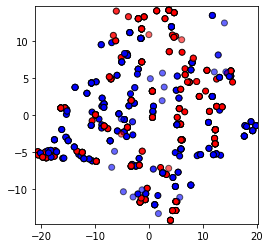

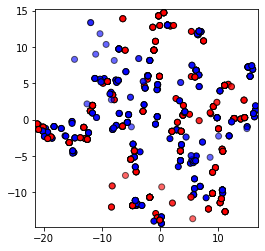

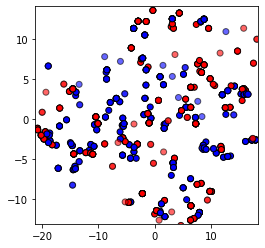

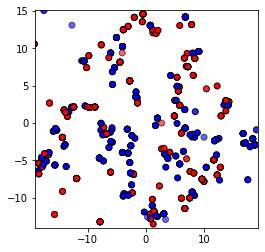

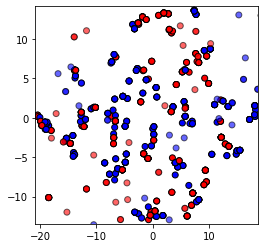

,KNN,Linear SVM,RBF SVM,Logistic Regr,Decision Tree,Random Forest,MLP,AdaBoost,Naive Bayes
0,0.255507,0.491345,0.512195,0.386507,0.419158,0.299371,0.558222,0.386900,0.430370
1,0.697595,0.432200,0.488493,0.366162,0.511715,0.513788,0.475327,0.546962,0.570496
2,0.467726,0.426536,0.542353,0.622504,0.524617,0.425858,0.520934,0.310913,0.582962
3,0.390422,0.598214,0.355519,0.517857,0.474026,0.489448,0.572240,0.463474,0.500812
4,0.478125,0.621875,0.451562,0.593750,0.504687,0.454688,0.529687,0.471875,0.450000
Avg,0.457875,0.514034,0.470025,0.497356,0.486841,0.436630,0.531282,0.436025,0.506928
